# 나이브 베이스 분류기(Naive Bayes Classification)

* 베이즈 정리를 적용한 확률적 분류 알고리즘
* 모든 특성들이 독립임을 가정 (naive 가정)
* 입력 특성에 따라 3개의 분류기 존재
  * 가우시안 나이브 베이즈 분류기(설명변수: 연속형)
  * 베르누이 나이브 베이즈 분류기(같은 범주형 변수일 때, 범주가 2개밖에 없는 이진형)
  * 다항 나이브 베이즈 분류기(설명면수: 범주형)

## 나이브 베이즈 분류기의 확률 모델

* 나이브 베이즈는 조건부 확률 모델
* *N*개의 특성을 나타내는 벡터 **x**를 입력 받아 k개의 가능한 확률적 결과를 출력

\begin{equation}
p(C_k | x_1,...,x_n)
\end{equation}

* 위의 식에 베이즈 정리를 적용하면 다음과 같음

\begin{equation}
p(C_k | \textbf{x}) = \frac{p(C_k)p(\textbf{x}|C_k)}{p(\textbf{x})}
\end{equation}

* 위의 식에서 분자만이 출력 값에 영향을 받기 때문에 분모 부분을 상수로 취급할 수 있음

\begin{equation}
\begin{split}
p(C_k | \textbf{x}) & \propto p(C_k)p(\textbf{x}|C_k) \\
& \propto p(C_k, x_1, ..., x_n)
\end{split}
\end{equation}

* 위의 식을 연쇄 법칙을 사용해 다음과 같이 쓸 수 있음

\begin{equation}
\begin{split}
p(C_k, x_1, ..., x_n) & = p(C_k)p(x_1, ..., x_n | C_k) \\
& = p(C_k)p(x_1 | C_k)p(x_2, ..., x_n | C_k, x_1) \\
& = p(C_k)p(x_1 | C_k)p(x_2 | C_k, x_1)p(x_3, ..., x_n | C_k, x_1, x_2) \\
& = p(C_k)p(x_1 | C_k)p(x_2 | C_k, x_1)...p(x_n | C_k, x_1, x_2, ..., x_{n-1})
\end{split}
\end{equation}

* 나이브 베이즈 분류기는 모든 특성이 독립이라고 가정하기 때문에 위의 식을 다음과 같이 쓸 수 있음

\begin{equation}
\begin{split}
p(C_k, x_1, ..., x_n) & \propto p(C_k)p(x_1|C_k)p(x_2|C_k)...p(x_n|C_k) \\
& \propto p(C_k) \prod_{i=1}^{n} p(x_i|C_k)
\end{split}
\end{equation}

* 위의 식을 통해 나온 값들 중 가장 큰 값을 갖는 클래스가 예측 결과

\begin{equation}
\hat{y} = \underset{k}{\arg\max} \; p(C_k) \prod_{i=1}^{n} p(x_i|C_k)
\end{equation}

In [2]:
import numpy as np
import pandas as pd

from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.datasets import fetch_covtype, fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn import metrics

In [ ]:
prior = [.45, .3, .15, .1]
likelihood = [[.3, .3, .4], [.7, .2, .1], [.15, .5, .35], [.6, .2, .2]]

idx = 0
for c, xs in zip(prior, likelihood):
  result = 1.

  for x in xs:
    result *= x
  result *= c

  idx += 1
  print(f'{idx}번째 클래스의 가능성: {result}')

1번째 클래스의 가능성: 0.0162
2번째 클래스의 가능성: 0.0042
3번째 클래스의 가능성: 0.0039375
4번째 클래스의 가능성: 0.0024000000000000002


## 산림 토양 데이터
* 산림 지역 토양의 특징 데이터
* 토양이 어떤 종류에 속하는지 예측
* https://archive.ics.uci.edu/ml/datasets/Covertype 에서 데이터의 자세한 설명 확인 가능

In [3]:
convtype = fetch_covtype()
print(convtype.DESCR)

.. _covtype_dataset:

Forest covertypes
-----------------

The samples in this dataset correspond to 30×30m patches of forest in the US,
collected for the task of predicting each patch's cover type,
i.e. the dominant species of tree.
There are seven covertypes, making this a multiclass classification problem.
Each sample has 54 features, described on the
`dataset's homepage <https://archive.ics.uci.edu/ml/datasets/Covertype>`__.
Some of the features are boolean indicators,
while others are discrete or continuous measurements.

**Data Set Characteristics:**

    =================   ============
    Classes                        7
    Samples total             581012
    Dimensionality                54
    Features                     int
    =================   ============

:func:`sklearn.datasets.fetch_covtype` will load the covertype dataset;
it returns a dictionary-like object
with the feature matrix in the ``data`` member
and the target values in ``target``.
The dataset will be d

In [4]:
pd.DataFrame(convtype.data)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396.0,153.0,20.0,85.0,17.0,108.0,240.0,237.0,118.0,837.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581008,2391.0,152.0,19.0,67.0,12.0,95.0,240.0,237.0,119.0,845.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581009,2386.0,159.0,17.0,60.0,7.0,90.0,236.0,241.0,130.0,854.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581010,2384.0,170.0,15.0,60.0,5.0,90.0,230.0,245.0,143.0,864.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
convtype.target

array([5, 5, 2, ..., 3, 3, 3], dtype=int32)

### 학습, 평가 데이터 분류

In [6]:
convtype_X = convtype.data
convtype_y = convtype.target

In [7]:
convtype_X_train, convtype_X_test, convtype_y_train, convtype_y_test = train_test_split(convtype_X, convtype_y, test_size=.2)

In [8]:
print('전체 데이터 크기: {}'.format(convtype_X.shape))
print('학습 데이터 크기: {}'.format(convtype_X_train.shape))
print('평가 데이터 크기: {}'.format(convtype_X_test.shape))

전체 데이터 크기: (581012, 54)
학습 데이터 크기: (464809, 54)
평가 데이터 크기: (116203, 54)


### 전처리

#### 전처리 전 데이터

In [9]:
convtype_df = pd.DataFrame(data=convtype_X)
convtype_df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226,0.448865,0.051434,0.436074,0.063627,0.005217,0.012952,0.008301,0.021335,0.002749,0.011316,0.000181,0.000308,0.001974,0.056168,0.021359,0.051584,0.030001,0.001031,0.000005,0.004897,0.005890,0.003268,0.006921,0.015936,0.001442,0.057439,0.099399,0.036622,0.000816,0.004456,0.001869,0.001628,0.198356,0.051927,0.044175,0.090392,0.077716,0.002773,0.003255,0.000205,0.000513,0.026803,0.023762,0.015060
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210,0.497379,0.220882,0.495897,0.244087,0.072039,0.113066,0.090731,0.144499,0.052356,0.105775,0.013442,0.017550,0.044387,0.230245,0.144579,0.221186,0.170590,0.032092,0.002272,0.069804,0.076518,0.057077,0.082902,0.125228,0.037950,0.232681,0.299197,0.187833,0.028551,0.066605,0.043193,0.040318,0.398762,0.221879,0.205483,0.286743,0.267725,0.052584,0.056957,0.014310,0.022641,0.161508,0.152307,0.121791
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3858.000000,360.000000,66.000000,1397

In [10]:
convtype_train_df = pd.DataFrame(data=convtype_X_train)
convtype_train_df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53
count,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.00000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000
mean,2959.250634,155.644355,14.099144,269.359444,46.357558,2350.512032,212.137256,223.316689,142.538871,1980.980112,0.448636,0.051477,0.435996,0.063891,0.005292,0.012893,0.008216,0.021374,0.002765,0.011340,0.000185,0.000321,0.001997,0.056550,0.021306,0.051813,0.029793,0.001058,0.000004,0.004916,0.005880,0.003223,0.00694,0.016060,0.001392,0.057525,0.099563,0.036744,0.000830,0.004408,0.001837,0.001586,0.197879,0.051699,0.043990,0.090299,0.077731,0.002795,0.003274,0.000183,0.000518,0.026854,0.023892,0.015073
std,280.158519,111.973443,7.487493,212.526420,58.209903,1558.070826,26.752045,19.763890,38.237718,1325.213313,0.497355,0.220969,0.495887,0.244558,0.072557,0.112815,0.090271,0.144629,0.052507,0.105885,0.013601,0.017901,0.044638,0.230981,0.144401,0.221649,0.170016,0.032517,0.002074,0.069942,0.076454,0.056678,0.08302,0.125708,0.037283,0.232843,0.299417,0.188133,0.028806,0.066248,0.042825,0.039788,0.398401,0.221418,0.205073,0.286611,0.267748,0.052791,0.057129,0.013522,0.022765,0.161657,0.152711,0.121843
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2996.000000,127.000000,13.000000,218.000000,29.000000,1998.000000,218.000000,226.000000,143.000000,1710.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3164.000000,261.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3858.000000,360.000000,65.000000,1390.000000

In [11]:
convtype_test_df = pd.DataFrame(data=convtype_X_test)
convtype_test_df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53
count,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.00000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000
mean,2959.823963,155.706617,14.121942,269.703304,46.664045,2348.684939,212.181217,223.326825,142.485831,1977.535700,0.449782,0.051264,0.436383,0.062572,0.004914,0.013184,0.00864,0.021178,0.002685,0.011222,0.000164,0.000258,0.001885,0.054637,0.021574,0.050670,0.030834,0.000921,0.000009,0.004819,0.005929,0.003451,0.006841,0.015438,0.001644,0.057098,0.098741,0.036135,0.000757,0.004647,0.001997,0.001799,0.200262,0.052839,0.044913,0.090764,0.077657,0.002685,0.003175,0.000293,0.000491,0.026600,0.023244,0.015008
std,279.289251,111.674981,7.491241,212.641765,58.634912,1563.987916,26.841230,19.787996,38.421555,1320.117065,0.497474,0.220536,0.495938,0.242192,0.069926,0.114062,0.09255,0.143980,0.051747,0.105337,0.012786,0.016066,0.043372,0.227272,0.145290,0.219324,0.172868,0.030331,0.002934,0.069253,0.076774,0.058643,0.082430,0.123289,0.040509,0.232031,0.298315,0.186627,0.027509,0.068011,0.044638,0.042372,0.400198,0.223712,0.207113,0.287274,0.267633,0.051747,0.056262,0.017103,0.022142,0.160912,0.150678,0.121586
min,1872.000000,0.000000,0.000000,0.000000,-159.000000,0.000000,36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2810.000000,59.000000,9.000000,108.000000,7.000000,1100.000000,198.000000,213.000000,119.000000,1024.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1994.000000,218.000000,226.000000,143.000000,1710.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3163.000000,260.000000,18.000000,390.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2548.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3850.000000,360.000000,66.000000,1397.00000

#### 전처리 과정

In [12]:
scaler = StandardScaler()
convtype_X_train_scale = scaler.fit_transform(convtype_X_train)
convtype_X_test_scale = scaler.transform(convtype_X_test)

#### 전처리 후 데이터
* 평균은 0에 가깝게, 표준평차는 1에 가깝게 정규화

In [13]:
convtype_train_df = pd.DataFrame(data=convtype_X_train_scale)
convtype_train_df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53
count,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05
mean,4.744401e-16,1.982545e-15,3.750568e-16,2.834107e-16,2.062275e-17,-2.101873e-16,2.978393e-16,-8.978182e-17,1.348522e-16,3.649095e-17,-9.229673e-16,2.604503e-15,-5.953509e-15,-6.833537e-15,3.691905e-15,6.823960e-15,1.845980e-15,-1.318723e-15,3.879487e-15,-2.911898e-15,-1.047722e-15,-9.945543e-15,-4.478616e-16,2.810023e-15,4.134015e-16,8.235914e-15,-2.187423e-15,1.034628e-14,-6.282009e-15,4.333424e-15,4.479821e-15,5.049927e-16,-1.376178e-15,4.988382e-15,-6.164401e-15,-4.565218e-15,1.060778e-15,3.010758e-15,-5.220783e-15,-2.601095e-15,-1.304066e-15,-5.090807e-15,3.195151e-15,5.662486e-15,-4.318565e-15,-1.380864e-14,2.212832e-15,4.287442e-15,-3.410396e-15,-3.788100e-15,4.581954e-15,-3.930881e-15,-3.228205e-15,-9.544812e-15
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-3.927247e+00,-1.390013e+00,-1.883028e+00,-1.267418e+00,-3.768393e+00,-1.508606e+00,-7.929767e+00,-1.129924e+01,-3.727707e+00,-1.494840e+00,-9.020441e-01,-2.329608e-01,-8.792258e-01,-2.612497e-01,-7.294283e-02,-1.142886e-01,-9.101837e-02,-1.477877e-01,-5.265207e-02,-1.070991e-01,-1.360355e-02,-1.790711e-02,-4.472710e-02,-2.448259e-01,-1.475443e-01,-2.337604e-01,-1.752363e-01,-3.255182e-02,-2.074334e-03,-7.028716e-02,-7.690651e-02,-5.686167e-02,-8.360019e-02,-1.277596e-01,-3.733510e-02,-2.470542e-01,-3.325244e-01,-1.953094e-01,-2.882948e-02,-6.654157e-02,-4.290333e-02,-3.985117e-02,-4.966839e-01,-2.334890e-01,-2.145094e-01,-3.150601e-01,-2.903139e-01,-5.293891e-02,-5.731684e-02,-1.352421e-02,-2.277634e-02,-1.661177e-01,-1.564491e-01,-1.237074e-01
25%,-5.363064e-01,-8.720323e-01,-6.810223e-01,-7.592450e-01,-6.761324e-01,-7.987528e-01,-5.284557e-01,-5.219975e-01,-6.155936e-01,-7.221337e-01,-9.020441e-01,-2.329608e-01,-8.792258e-01,-2.612497e-01,-7.294283e-02,-1.142886e-01,-9.101837e-02,-1.477877e-01,-5.265207e-02,-1.070991e-01,-1.360355e-02,-1.790711e-02,-4.472710e-02,-2.448259e-01,-1.475443e-01,-2.337604e-01,-1.752363e-01,-3.255182e-02,-2.074334e-03,-7.028716e-02,-7.690651e-02,-5.686167e-02,-8.360019e-02,-1.277596e-01,-3.733510e-02,-2.470542e-01,-3.325244e-01,-1.953094e-01,-2.882948e-02,-6.654157e-02,-4.290333e-02,-3.985117e-02,-4.966839e-01,-2.334890e-01,-2.145094e-01,-3.150601e-01,-2.903139e-01,-5.293891e-02,-5.731684e-02,-1.352421e-02,-2.277634e-02,-1.661177e-01,-1.564491e-01,-1.237074e-01
50%,1.311736e-01,-2.558141e-01,-1.467975e-01,-2.416617e-01,-2.981894e-01,-2.262493e-01,2.191515e-01,1.357685e-01,1.205955e-02,-2.044806e-01,-9.020441e-01,-2.329608e-01,-8.792258e-0

In [14]:
convtype_test_df = pd.DataFrame(data=convtype_X_test_scale)
convtype_test_df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53
count,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000
mean,0.002046,0.000556,0.003045,0.001618,0.005265,-0.001173,0.001643,0.000513,-0.001387,-0.002599,0.002304,-0.000965,0.000780,-0.005394,-0.005219,0.002574,0.004694,-0.001355,-0.001516,-0.001118,-0.001582,-0.003485,-0.002507,-0.008282,0.001861,-0.005156,0.006123,-0.004235,0.002074,-0.001385,0.000647,0.004023,-0.001193,-0.004947,0.006751,-0.001831,-0.002747,-0.003238,-0.002540,0.003604,0.003717,0.005353,0.005980,0.005148,0.004499,0.001619,-0.000275,-0.002079,-0.001733,0.008114,-0.001229,-0.001571,-0.004242,-0.000531
std,0.996898,0.997336,1.000502,1.000544,1.007302,1.003799,1.003335,1.001221,1.004809,0.996155,1.000240,0.998042,1.000105,0.990323,0.963748,1.011053,1.025250,0.995510,0.985538,0.994830,0.940075,0.897453,0.971634,0.983941,1.006154,0.989511,1.016780,0.932760,1.414212,0.990153,1.004175,1.034659,0.992895,0.980763,1.086526,0.996517,0.996320,0.991995,0.954979,1.026607,1.042344,1.064936,1.004511,1.010361,1.009949,1.002315,0.999570,0.980228,0.984822,1.264843,0.972670,0.995393,0.986683,0.997890
min,-3.880845,-1.390013,-1.883028,-1.267418,-3.527884,-1.508606,-6.584074,-11.299240,-3.727707,-1.494840,-0.902044,-0.232961,-0.879226,-0.261250,-0.072943,-0.114289,-0.091018,-0.147788,-0.052652,-0.107099,-0.013604,-0.017907,-0.044727,-0.244826,-0.147544,-0.233760,-0.175236,-0.032552,-0.002074,-0.070287,-0.076907,-0.056862,-0.083600,-0.127760,-0.037335,-0.247054,-0.332524,-0.195309,-0.028829,-0.066542,-0.042903,-0.039851,-0.496684,-0.233489,-0.214509,-0.315060,-0.290314,-0.052939,-0.057317,-0.013524,-0.022776,-0.166118,-0.156449,-0.123707
25%,-0.532737,-0.863102,-0.681022,-0.759245,-0.676132,-0.802604,-0.528456,-0.521997,-0.615594,-0.722134,-0.902044,-0.232961,-0.879226,-0.261250,-0.072943,-0.114289,-0.091018,-0.147788,-0.052652,-0.107099,-0.013604,-0.017907,-0.044727,-0.244826,-0.147544,-0.233760,-0.175236,-0.032552,-0.002074,-0.070287,-0.076907,-0.056862,-0.083600,-0.127760,-0.037335,-0.247054,-0.332524,-0.195309,-0.028829,-0.066542,-0.042903,-0.039851,-0.496684,-0.233489,-0.214509,-0.315060,-0.290314,-0.052939,-0.057317,-0.013524,-0.022776,-0.166118,-0.156449,-0.123707
50%,0.131174,-0.255814,-0.146797,-0.241662,-0.281010,-0.228817,0.219151,0.135768,0.012060,-0.204481,-0.902044,-0.232961,-0.879226,-0.261250,-0.072943,-0.114289,-0.091018,-0.147788,-0.052652,-0.107099,-0.013604,-0.017907,-0.044727,-0.244826,-0.147544,-0.233760,-0.175236,-0.032552,-0.002074,-0.070287,-0.076907,-0.056862,-0.083600,-0.127760,-0.037335,-0.247054,-0.332524,-0.195309,-0.028829,-0.066542,-0.042903,-0.039851,-0.496684,-0.233489,-0.214509,-0.315060,-0.290314,-0.052939,-0.057317,-0.013524,-0.022776,-0.166118,-0.156449,-0.123707
75%,0.727265,0.931969,0.520983,0.567650,0.388980,0.627371,0.705096,0.692340,0.665865,0.427871,1.108593,-0.232961,1.137364,-0.261250,-0.072943,-0.114289,-0.091018,-0.147788,-0.052652,-0.107099,-0.013604,-0.017907,-0.044727,-0.244826,-0.147544,-0.233760,-0.175236,-0.032552,-0.002074,-0.070287,-0.076907,-0.056862,-0.083600,-0.127760,-0.037335,-0.247054,-0.332524,-0.195309,-0.028829,-0.066542,-0.042903,-0.039851,-0.496684,-0.233489,-0.214509,-0.3

## 20 Newsgroup 데이터
* 뉴스 기사가 어느 그룹에 속하는지 분류
* 뉴스 기사는 텍스트 데이터이기 때문에 특별한 전처리 과정이 필요

In [ ]:
newsgroup = fetch_20newsgroups()
print(newsgroup.DESCR)

In [ ]:
newsgroup.data

In [ ]:
newsgroup.target_names

### 학습, 평가 데이터 분류

In [ ]:
newgroup_train = fetch_20newsgroups(subset='train')
newsgroup_test = fetch_20newsgroups(subset="test")

In [ ]:
X_train, y_train = newgroup_train.data, newgroup_train.target
X_test, y_test = newsgroup_test.data, newsgroup_test.target

### 벡터화
* 텍스트 데이터는 기계학습 모델에 입력 할 수 없음
* 벡터화는 텍스트 데이터를 실수 벡터로 변환해 기계학습 모델에 입력 할 수 있도록 하는 전처리 과정
* Scikit-learn에서는 Count, Tf-idf, Hashing 세가지 방법을 지원

#### CountVectorizer
* 문서에 나온 단어의 수를 세서 벡터 생성

In [ ]:
count_vectorizer = CountVectorizer()

In [ ]:
X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

데이터를 희소 행렬 형태로 표현

In [ ]:
X_train_count

<11314x130107 sparse matrix of type '<class 'numpy.int64'>'
	with 1787565 stored elements in Compressed Sparse Row format>

In [ ]:
for v in X_train_count[0]:
  print(v)

#### HashingVectorizer
* 각 단어를 해쉬 값으로 표현
* 미리 정해진 크기의 벡터로 표현

In [ ]:
hash_vectorizer = HashingVectorizer(n_features=1000)

In [ ]:
X_train_hash = hash_vectorizer.fit_transform(X_train)
X_test_hash = hash_vectorizer.transform(X_test)

In [ ]:
X_train_hash

<11314x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 1550687 stored elements in Compressed Sparse Row format>

In [ ]:
print(X_train_hash[0])

#### TfidfVectorizer
* 문서에 나온 단어 빈도(term frequency)와 역문서 빈도(inverse document frequency)를 곱해서 구함
* 각 빈도는 일반적으로 로그 스케일링 후 사용(빈번하게 나온 단어들은 스케일링함)
* $tf(t, d) = log(f(t, d) + 1)$
* $idf(t, D) = \frac{|D|}{|d \in D : t \in d| + 1}$
* $tfidf(t, d, D) = tf(t, d) \times idf(t, D)$

In [ ]:
tfidf_vectorizer = TfidfVectorizer()

In [ ]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [ ]:
X_train_tfidf

<11314x130107 sparse matrix of type '<class 'numpy.float64'>'
	with 1787565 stored elements in Compressed Sparse Row format>

In [ ]:
for v in X_train_tfidf[0]:
  print(v)

## 가우시안 나이브 베이즈

* 입력 특성이 가우시안(정규) 분포를 갖는다고 가정

In [ ]:
model = GaussianNB()
model.fit(convtype_X_train_scale, convtype_y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
predict = model.predict(convtype_X_train_scale)
acc = metrics.accuracy_score(convtype_y_train, predict)
f1 = metrics.f1_score(convtype_y_train, predict, average=None)

print('Train Accuracy: {}'.format(acc))
print('Train F1 score: {}'.format(f1))

Train Accuracy: 0.08817170063402387
Train F1 score: [0.04021629 0.01813037 0.33623732 0.13973059 0.04344321 0.07613503
 0.23155234]


In [ ]:
predict = model.predict(convtype_X_test_scale)
acc = metrics.accuracy_score(convtype_y_test, predict)
f1 = metrics.f1_score(convtype_y_test, predict, average=None)

print('Test Accuracy: {}'.format(acc))
print('Test F1 score: {}'.format(f1))

Test Accuracy: 0.0880441985146683
Test F1 score: [0.04143371 0.01722807 0.32995502 0.13273999 0.04320679 0.08014248
 0.23451982]


In [ ]:
import matplotlib.pyplot as plt
plt.style.use(['seaborn-whitegrid'])
from sklearn.datasets import make_blobs

In [ ]:
def make_meshgrid(x, y, h=.2):
  x_min, x_max = x.min(), x.max()+1
  y_min, y_max = y.min(), y.max()+1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                       np.arange(y_min, y_max, h))
  
  return xx, yy

def plot_contours(clf, xx, yy, **params):
  Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  out = plt.contourf(xx, yy, Z, **params)

  return out

In [ ]:
X, y = make_blobs(n_samples=1000)

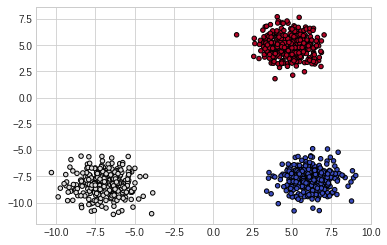

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

In [ ]:
model = GaussianNB()
model.fit(X, y)

GaussianNB(priors=None, var_smoothing=1e-09)

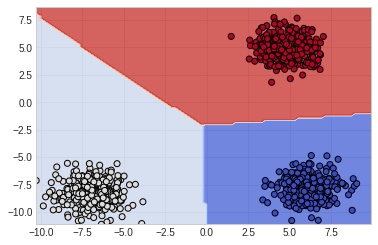

In [ ]:
xx, yy = make_meshgrid(X[:, 0], X[:, 1])
plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, alpha=.8)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k');

## 베르누이 나이브 베이즈

* 입력 특성이 베르누이 분포에 의해 생성된 이진 값을 갖는 다고 가정

### 학습 및 평가 (Count)

In [ ]:
model = BernoulliNB()
model.fit(X_train_count, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [ ]:
predict = model.predict(X_train_count)
acc = metrics.accuracy_score(y_train, predict)
f1 = metrics.f1_score(y_train, predict, average=None)

print("Train Accuracy: {}".format(acc))
print('Train F1 Score: {}'.format(f1))

Train Accuracy: 0.7821283365741559
Train F1 Score: [0.80096502 0.8538398  0.13858268 0.70686337 0.85220126 0.87944493
 0.51627694 0.84532672 0.89064976 0.87179487 0.94561404 0.91331546
 0.84627832 0.89825848 0.9047619  0.79242424 0.84693878 0.84489796
 0.67329545 0.14742015]


In [ ]:
predict = model.predict(X_test_count)
acc = metrics.accuracy_score(y_test, predict)
f1 = metrics.f1_score(y_test, predict, average=None)

print("Test Accuracy: {}".format(acc))
print('Test F1 Score: {}'.format(f1))

Test Accuracy: 0.6307753584705258
Test F1 Score: [0.47086247 0.60643564 0.01       0.56014047 0.6953405  0.70381232
 0.44829721 0.71878646 0.81797753 0.81893491 0.90287278 0.74794521
 0.61647059 0.64174455 0.76967096 0.63555114 0.64285714 0.77971474
 0.31382979 0.00793651]


### 학습 및 평가 (Hash)

In [ ]:
model = BernoulliNB()
model.fit(X_train_hash, y_train)

In [ ]:
predict = model.predict(X_train_hash)
acc = metrics.accuracy_score(y_train, predict)
f1 = metrics.f1_score(y_train, predict, average=None)

print("Train Accuracy: {}".format(acc))
print('Train F1 Score: {}'.format(f1))

Train Accuracy: 0.5951917977726711
Train F1 Score: [0.74226804 0.49415205 0.45039019 0.59878155 0.57327935 0.63929619
 0.35390947 0.59851301 0.72695347 0.68123862 0.79809524 0.70532319
 0.54703833 0.66862745 0.61889927 0.74707471 0.6518668  0.60485269
 0.5324165  0.54576271]


In [ ]:
predict = model.predict(X_test_hash)
acc = metrics.accuracy_score(y_test, predict)
f1 = metrics.f1_score(y_test, predict, average=None)

print("Test Accuracy: {}".format(acc))
print('Test F1 Score: {}'.format(f1))

Test Accuracy: 0.4430430164630908
Test F1 Score: [0.46678636 0.33826638 0.29391892 0.45743329 0.41939121 0.46540881
 0.34440068 0.46464646 0.62849873 0.53038674 0.63782051 0.55251799
 0.32635983 0.34266886 0.46105919 0.61780105 0.46197991 0.54591837
 0.27513228 0.3307888 ]


### 학습 및 평가 (Tf-idf)

In [ ]:
model = BernoulliNB()
model.fit(X_train_tfidf, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [ ]:
predict = model.predict(X_train_tfidf)
acc = metrics.accuracy_score(y_train, predict)
f1 = metrics.f1_score(y_train, predict, average=None)

print("Train Accuracy: {}".format(acc))
print('Train F1 Score: {}'.format(f1))

Train Accuracy: 0.7821283365741559
Train F1 Score: [0.80096502 0.8538398  0.13858268 0.70686337 0.85220126 0.87944493
 0.51627694 0.84532672 0.89064976 0.87179487 0.94561404 0.91331546
 0.84627832 0.89825848 0.9047619  0.79242424 0.84693878 0.84489796
 0.67329545 0.14742015]


In [ ]:
predict = model.predict(X_test_tfidf)
acc = metrics.accuracy_score(y_test, predict)
f1 = metrics.f1_score(y_test, predict, average=None)

print("Test Accuracy: {}".format(acc))
print('Test F1 Score: {}'.format(f1))

Test Accuracy: 0.6307753584705258
Test F1 Score: [0.47086247 0.60643564 0.01       0.56014047 0.6953405  0.70381232
 0.44829721 0.71878646 0.81797753 0.81893491 0.90287278 0.74794521
 0.61647059 0.64174455 0.76967096 0.63555114 0.64285714 0.77971474
 0.31382979 0.00793651]


### 시각화

In [ ]:
X, y = make_blobs(n_samples=1000)

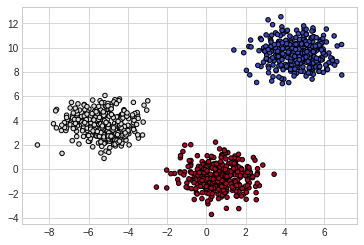

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

In [ ]:
model = BernoulliNB()
model.fit(X, y)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

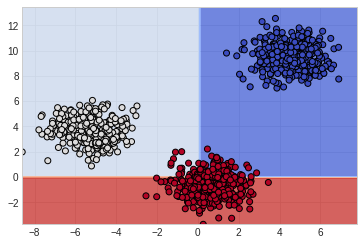

In [ ]:
xx, yy = make_meshgrid(X[:, 0], X[:, 1])
plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, alpha=.8)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k');

## 다항 나이브 베이즈

* 입력 특성이 다항분포에 의해 생성된 빈도수 값을 갖는 다고 가정

### 학습 및 평가 (Count)

In [ ]:
model = MultinomialNB()
model.fit(X_train_count, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
predict = model.predict(X_train_count)
acc = metrics.accuracy_score(y_train, predict)
f1 = metrics.f1_score(y_train, predict, average=None)

print("Train Accuracy: {}".format(acc))
print('Train F1 Score: {}'.format(f1))

Train Accuracy: 0.9245182959165635
Train F1 Score: [0.95228426 0.904      0.25073746 0.81402003 0.96669513 0.88350983
 0.90710383 0.97014925 0.98567818 0.99325464 0.98423237 0.95399516
 0.95703454 0.98319328 0.98584513 0.95352564 0.97307002 0.97467249
 0.95157895 0.86526946]


In [ ]:
predict = model.predict(X_test_count)
acc = metrics.accuracy_score(y_test, predict)
f1 = metrics.f1_score(y_test, predict, average=None)

print("Test Accuracy: {}".format(acc))
print('Test F1 Score: {}'.format(f1))

Test Accuracy: 0.7728359001593202
Test F1 Score: [0.77901431 0.7008547  0.00501253 0.64516129 0.79178082 0.73370166
 0.76550681 0.88779285 0.93951094 0.91390728 0.94594595 0.78459938
 0.72299169 0.84635417 0.86029412 0.80846561 0.78665077 0.89281211
 0.60465116 0.48695652]


### 학습 및 평가 (Tf-idf)

In [ ]:
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
predict = model.predict(X_train_tfidf)
acc = metrics.accuracy_score(y_train, predict)
f1 = metrics.f1_score(y_train, predict, average=None)

print("Train Accuracy: {}".format(acc))
print('Train F1 Score: {}'.format(f1))

Train Accuracy: 0.9326498143892522
Train F1 Score: [0.87404162 0.95414462 0.95726496 0.92863002 0.97812773 0.97440273
 0.91090909 0.97261411 0.98659966 0.98575021 0.98026316 0.94033413
 0.9594478  0.98032506 0.97755611 0.77411003 0.93506494 0.97453907
 0.90163934 0.45081967]


In [ ]:
predict = model.predict(X_test_tfidf)
acc = metrics.accuracy_score(y_test, predict)
f1 = metrics.f1_score(y_test, predict, average=None)

print("Test Accuracy: {}".format(acc))
print('Test F1 Score: {}'.format(f1))

Test Accuracy: 0.7738980350504514
Test F1 Score: [0.63117871 0.72       0.72778561 0.72104019 0.81309686 0.81643836
 0.7958884  0.88135593 0.93450882 0.91071429 0.92917167 0.73583093
 0.69732938 0.81907433 0.86559803 0.60728118 0.76286353 0.92225201
 0.57977528 0.24390244]


### 시각화

In [ ]:
X, y = make_blobs(n_samples=1000)

In [ ]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

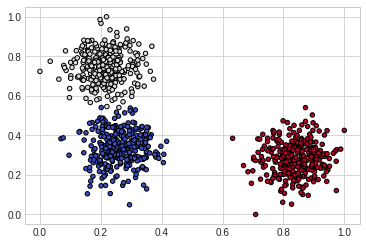

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

In [ ]:
model = MultinomialNB()
model.fit(X, y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

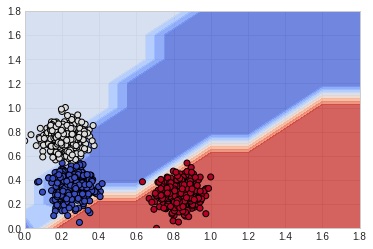

In [ ]:
xx, yy = make_meshgrid(X[:, 0], X[:, 1])
plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, alpha=.8)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k');